# About Program

**概要**  
アップロードされた画像を解析（※）し、画像に映っている人の骨格を検出します。  
検出された骨格は、アップロード画像に書き加えられる形で表示され、保存することもできます。

※ 解析には google が開発した骨格検知AI、mediapipe pose を使用
  
<img src="https://raw.githubusercontent.com/TakanariShimbo/TestGoogleColab/main/Explain_AnalysisPOSE_Image/about.jpg" width = 100%>

**使用手順**   
以下の簡単な2ステップで解析できます。  
1. Google アカウントにログイン  
サイト右上のログインボタンからログイン  
ログイン済みの方はステップ2へ  
<img src="https://raw.githubusercontent.com/TakanariShimbo/TestGoogleColab/main/Explain_AnalysisPOSE_Image/step1.png" width = 100%>
  
2. すべてのセルを実行  
スマホ　 : サイト左上の三本線 > ランタイム > すべてのセルを実行  
パソコン : サイト上部タブのランタイム > すべてのセルを実行  
※ 警告が出ますが続行してください  
※ 2回目以降 > 再起動してすべてのセルを実行  
<img src="https://raw.githubusercontent.com/TakanariShimbo/TestGoogleColab/main/Explain_AnalysisPOSE_Image/step2.png" width = 100%>
  
  
「2.すべてのセルを実行」の前にSet Paramsを設定することで以下のことができます。
*   あなたのデバイス内の画像を解析
*   解析結果のダウンロード
<img src="https://raw.githubusercontent.com/TakanariShimbo/TestGoogleColab/main/Explain_AnalysisPOSE_Image/edit_parm.png" width = 100%>





# Set Params

**UseSelfImg** : 画像アップロードのON/OFF  
  
デフォルトはFalse。Trueにするとあなたのデバイス内の画像を解析できます。  
Trueにした場合は、「2.すべてのセルを実行」の後、項目：Upload Images まで下にスワイプし、写真を追加してください。



In [1]:
UseSelfImg = False

**SaveResult** : 結果ダウンロードのON/OFF  
  
デフォルトはFalse。Trueにすると結果画像がダウンロードされます。

In [2]:
SaveResult = False

# Imports

In [3]:
!pip install mediapipe

In [4]:
from google.colab import files
from google.colab.patches import cv2_imshow
import os
from datetime import datetime
from skimage import io
import math
import numpy as np
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [5]:
now = datetime.now()
dirname = 'data_' + now.strftime('%Y%m%d_%H%M%S')
os.mkdir(dirname)
os.chdir(dirname)

# Upload Images

UseSelfImg にTrueにした場合は画像をアップロードしてください。（複数選択可）  
Falseの場合は自動で大谷選手の画像がアップロードされます。

In [6]:
if UseSelfImg:
  uploaded = files.upload()

else:
  file_name = "Sample_AnalysisPOSE_Image.jpg"
  !wget https://raw.githubusercontent.com/TakanariShimbo/TestGoogleColab/main/Sample_AnalysisPOSE_Image.jpg

  uploaded = {
      file_name : None
  }  

--2021-09-08 14:06:20--  https://raw.githubusercontent.com/TakanariShimbo/TestGoogleColab/main/Sample_AnalysisPOSE_Image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33955 (33K) [image/jpeg]
Saving to: ‘Sample_AnalysisPOSE_Image.jpg’

Sample_AnalysisPOSE 100%[===================>]  33.16K  --.-KB/s    in 0.004s  

2021-09-08 14:06:20 (8.58 MB/s) - ‘Sample_AnalysisPOSE_Image.jpg’ saved [33955/33955]



# Analysis

In [7]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

Sample_AnalysisPOSE_Image.jpg


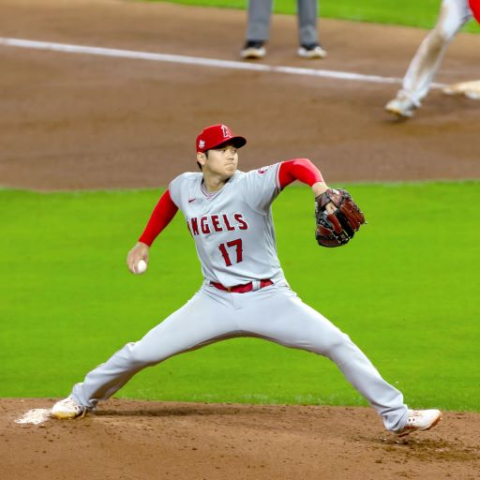

In [8]:
# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}

# Show imput images.
for name, image in images.items():
  print(name)   
  resize_and_show(image)

Sample_AnalysisPOSE_Image.jpg:


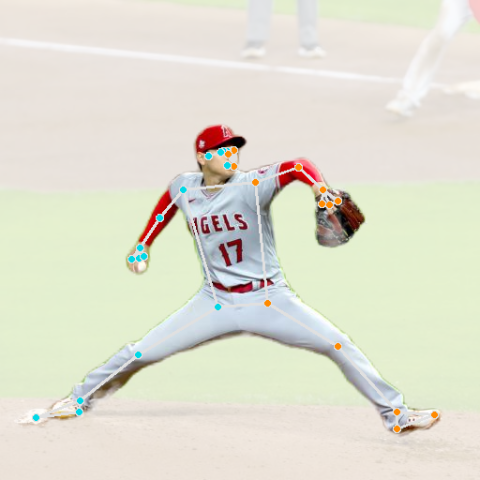

In [9]:
# Create dict for result images.
result_images = {}

# Run MediaPipe Pose and draw pose landmarks.
with mp_pose.Pose(
    static_image_mode=True, 
    min_detection_confidence=0.5, 
    model_complexity=2,
    enable_segmentation=True) as pose:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Check Image name.
    print(f'{name}:')
    annotated_image = image.copy()

    # Draw pose segmentation.
    red_img = np.zeros_like(annotated_image, dtype=np.uint8)
    red_img[:, :] = (255,255,255)
    segm_2class = 0.2 + 0.8 * results.segmentation_mask
    segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
    annotated_image = annotated_image * segm_2class + red_img * (1 - segm_2class)

    # Draw pose landmarks.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
    # Show result images.
    resize_and_show(annotated_image)

    # Add annotated image to result images dict.
    result_images['Result_'+name] = annotated_image

In [10]:
for name, image in result_images.items():
  cv2.imwrite(name, image)

# Download Images



In [11]:
if SaveResult:
  for name in result_images.keys():
    files.download(name)